<a href="https://colab.research.google.com/github/catalinamagalvan/PySimMIBCI/blob/main/notebooks/Example_generate_data_for_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Simulation of user-specific data for augmentation
This Google colab notebook illustrates how to generate user-specific MI-EEG for data augmentation. First, aperiodic and periodic parameters are extracted from real MI-EEG and then data are simulated employing such parameters. In this example, 100 trials are generated for subject 27 of OpenBMI dataset (Dataset-2).

Note: In order to see the impact of using these simulated data for data augmentation see the example [Example_cross_session_data_augmentation.ipynb](https://github.com/catalinamagalvan/PySimMIBCI/blob/main/FBCNet%20Toolbox/Example_cross_session_data_augmentation.ipynb).

##Clone repository

In [1]:
!git clone https://github.com/catalinamagalvan/PySimMIBCI.git

Cloning into 'PySimMIBCI'...
remote: Enumerating objects: 477, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 477 (delta 93), reused 102 (delta 60), pack-reused 322
Receiving objects: 100% (477/477), 1.48 MiB | 17.62 MiB/s, done.
Resolving deltas: 100% (245/245), done.


##Install and import the required Python libraries

In [2]:
!pip install mne==1.3.0
!pip install fooof==1.0.0
!pip install colorednoise==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 33.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 KB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from scipy.io import loadmat
import os
import mne
import numpy as np
from mne.datasets import fetch_fsaverage
import sys
sys.path.insert(1, os.path.join('PySimMIBCI', 'src'))
from PSD_parameterization import fit_user_params, plot_PSD_FOOOF
from simulation import (set_up_source_forward, generate_when, generate_what,
                        generate_where, save_mat_simulated_data)
from noise import add_aperiodic_activity, add_eye_movement
sys.path.insert(1, os.path.join('PySimMIBCI', 'utils'))
from datasets import (load_and_epoch_OpenBMI_by_ftp, create_OpenBMI_info,
                      raw_from_OpenBMI_data_by_ftp)
from plots import plot_raw_2_channels

## Set up simulation parameters

In [4]:
# MI IDs
MI_tasks_IDs = {'MI/left': 1, 'MI/right': 2}
# Sample frequency
sfreq = 1000
# Number of trials
N_trials = 100
# MI trial duration in ms
MI_duration = 4500
# ERD percentage
reduction = 0.5

## Extract user-specific aperiodic and periodic parameters
Download real MI-EEG data from session 1 of subject 27 of OpenBMI dataset and create corresponding MNE Epochs object.

In [5]:
epochs_real, epochs_real_right, epochs_real_left = load_and_epoch_OpenBMI_by_ftp(subject=27,
                                                                                 session=1,
                                                                                 epoch_window=[0, 4],
                                                                                 picks=None)

Generate suitable mne Info object for OpenBMI data.

In [6]:
info = create_OpenBMI_info()

Fit aperiodic and periodic parameters of real data.

In [7]:
user_params = fit_user_params(epochs_real, epochs_real_right, epochs_real_left)

##Set up source space and compute forward solution

Here, *fsaverage* head model is employed, which is a template brain based on a combination of 40 MRI scans of real brains.

In [8]:
subject = 'fsaverage'
fwd, source_simulator = set_up_source_forward(subject, info)

##Generate task-related when, what and where information
Create events, waveform and spatial information for the task-related component in right hand MI vs left hand MI scenario.

In [9]:
events_info = {0: {'label': 'MI/left', 'duration': MI_duration},
               1: {'label': 'MI/right', 'duration': MI_duration}}
when = generate_when(events_info, N_trials, sfreq)

what = generate_what(MI_tasks_IDs.keys(), when, user_params, MI_duration,
                     sfreq, N_trials, reduction)
where = generate_where(subject)

##Add task-related component to source simulator object

In [10]:
for label in what.keys():
    for task_ID, task in enumerate(MI_tasks_IDs.keys(), 1):
        when_task = when[np.where(when[:, 2] == task_ID)[0]]
        source_simulator.add_data(label=where[label],
                                  waveform=what[label][task],
                                  events=when_task)

##Simulate raw data

Project the source time series to sensor space.
For doing so, the `mne.simulation.SourceSimulator` object is given directly to the `mne.simulation.simulate_raw` function.

In [11]:
raw_sim = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
raw_sim.set_eeg_reference(ref_channels='average')

<RawArray | 62 x 450000 (450.0 s), ~212.9 MB, data loaded>

##Add non-task-related components


*   Aperiodic activity (background noise) to raw simulated data Here, user-specific aperiodic parameters are employed.
*   Eog artifacts by MNE function.
*   Eye-movement artifacts.


In [12]:
raw_sim = add_aperiodic_activity(raw_sim,
                                 exponent=user_params['aperiodic_params'][1],
                                 offset=user_params['aperiodic_params'][0])
mne.simulation.add_eog(raw_sim)
add_eye_movement(raw_sim)

##Epoch data

In [13]:
epochs_sim = mne.Epochs(raw_sim, when, MI_tasks_IDs, tmin=0, tmax=4,
                        baseline=None)
epochs_sim_right = epochs_sim['MI/right']
epochs_sim_left = epochs_sim['MI/left']

##Power spectrum analysis
Calculate and plot the power spectrum and the fitted FOOOF model for real and simulated MI-EEG data. Analysis is performed for each class (right and left hand MI) in channels C3 and C4 separately.

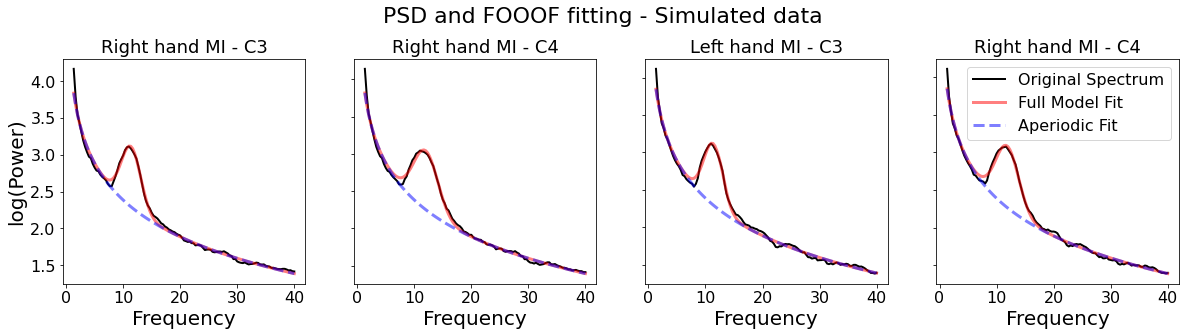

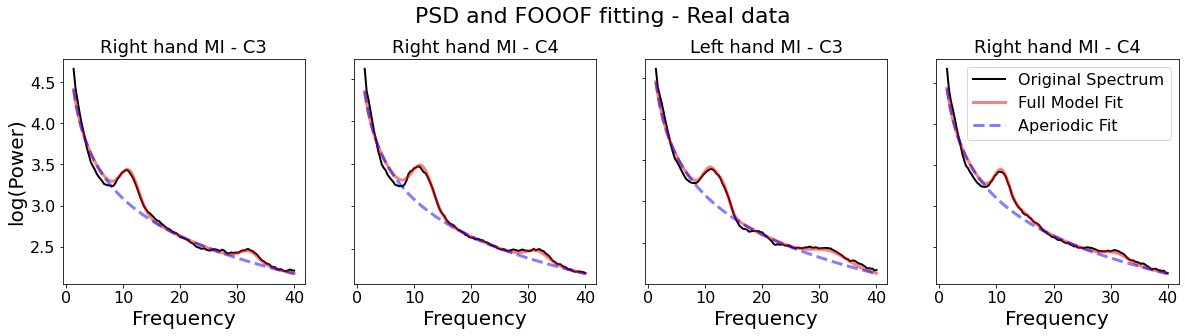

In [14]:
plot_PSD_FOOOF(epochs_sim_right, epochs_sim_left, title = 'Simulated data')
plot_PSD_FOOOF(epochs_real_right, epochs_real_left, title = 'Real data')


##Plot some EEG channels

Plot a 20 seconds segment of real and simulated MI-EEG data. Channels C3 and C4 are selected for these plots.

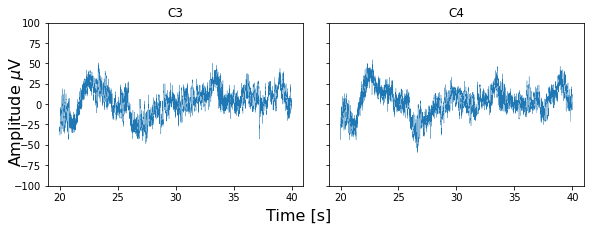

In [15]:
# Real data
raw_real = raw_from_OpenBMI_data_by_ftp(27, 1)
raw_real.filter(l_freq=0.05, h_freq=200, picks='eeg', method='iir',
                phase='zero')
plot_raw_2_channels(raw_real, start=20, duration=20)

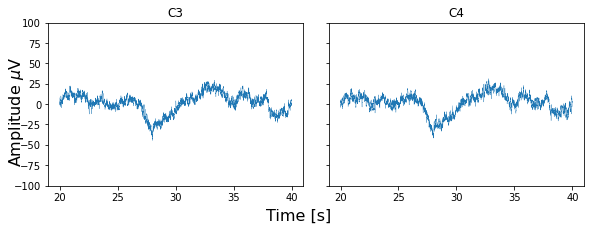

In [16]:
# Simulated data
raw_sim.filter(l_freq=0.05, h_freq=200, picks='eeg', method='iir',
               phase='zero')
plot_raw_2_channels(raw_sim, start=20, duration=20)

##Save generated data (optional)
Save simulated data in a .mat file compatible with FBCNet Toolbox functions.

In [17]:
spath = os.path.join('PySimMIBCI', 'lib', 'FBCNet', 'data', 'koreasim')
save_mat_simulated_data(raw_sim, when, spath, 's27.mat')